In [1]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import torchvision

In [2]:
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000
<PIL.Image.Image image mode=L size=28x28 at 0x19D248DE5F8> -> tensor(5)


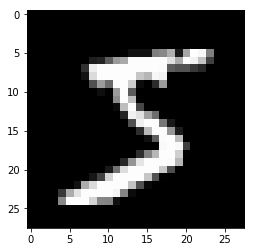

In [3]:
"""
Observing some of the data
"""
print("Number of samples in the training set:", len(training_data_set))
print("Number of samples in the test set:", len(test_data_set))
image, target = training_data_set[0]
print(image, "->", target)
plt.imshow(image)

In [4]:
"""
How to transform the data into vectors
"""
pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.2, 0.2, 0.2])
])
xs = pipeline(image)
xs.shape

torch.Size([1, 28, 28])

In [5]:
"""
Working with data loader for images
"""

# You need to transform the data to vectors to put it inside a data loader
training_data_set.transform = pipeline
test_data_set.transform = pipeline

data_loader = DataLoader(training_data_set, batch_size=2, shuffle=True)
for images, targets in data_loader:
    print(images)
    print(targets)
    break

tensor([[[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]],


        [[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]])
tensor([2, 9])


[Epoch 0] Training loss: 263.86878187954426
[Epoch 0] Accuracy: 54307/60000 (90.51%)
[Epoch 1] Training loss: 198.2725880742073
[Epoch 1] Accuracy: 54725/60000 (91.21%)
[Epoch 2] Training loss: 192.94620718806982
[Epoch 2] Accuracy: 54998/60000 (91.66%)
[Epoch 3] Training loss: 185.8310233876109
[Epoch 3] Accuracy: 55078/60000 (91.80%)
[Epoch 4] Training loss: 183.30597822368145
[Epoch 4] Accuracy: 55139/60000 (91.90%)


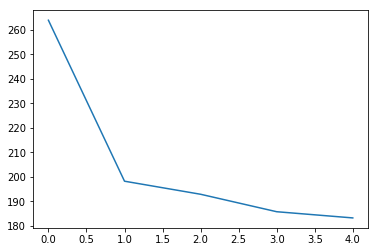

In [11]:
"""
Training a basic Linear classifier for images
"""

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

def train(model, epoch_count=10):
    training_data_set.transform = pipeline
    test_data_set.transform = pipeline   

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    training_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)
    test_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)

    losses = []

    for epoch in range(epoch_count):
        cumulative_loss = 0.
        model.train()
        for images, targets in training_data_loader:
            optimizer.zero_grad()
            got = model(images, with_softmax=False)
            loss = criterion(got, targets)
            cumulative_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("[Epoch {0}] Training loss: {1}".format(epoch, cumulative_loss))
        losses.append(cumulative_loss)

        correct = 0
        total = 0
        model.eval()
        for images, targets in test_data_loader:
            got = model(images, with_softmax=True)
            predicted = torch.argmax(got, dim=-1)
            predicted = predicted.view(-1)
            targets = targets.view(-1)
            correct += (predicted == targets).sum().item()
            total += len(targets)

        print("[Epoch {0}] Accuracy: {1}/{2} ({3:.2f}%)".format(epoch, correct, total, 100 * correct/total))

    plt.plot(losses)
    plt.show()
    
linear_model = LinearClassifier()
train(linear_model, epoch_count=5)

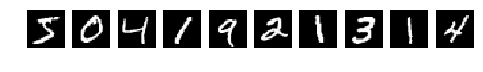

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [12]:
"""
Trying the model
"""

def predict(model, image_indexes):
    fig, ax = plt.subplots(figsize=(8, 8), ncols=len(image_indexes))
    predicted = []
    training_data_set.transform = None
    for image_idx in image_indexes:
        image, target = training_data_set[image_idx]
        xs = pipeline(image)
        xs = xs.unsqueeze(dim=0)
        ys = model(xs, with_softmax=True)
        predicted.append(torch.argmax(ys, dim=-1).item())
        ax[image_idx].imshow(image)
        ax[image_idx].set_axis_off()
    plt.show()
    print(predicted)

predict(linear_model, range(10))

[Epoch 0] Training loss: 255.5572955608368
[Epoch 0] Accuracy: 55157/60000 (91.93%)
[Epoch 1] Training loss: 158.93414087593555
[Epoch 1] Accuracy: 55809/60000 (93.02%)
[Epoch 2] Training loss: 129.46787618100643
[Epoch 2] Accuracy: 56800/60000 (94.67%)
[Epoch 3] Training loss: 111.41352344676852
[Epoch 3] Accuracy: 56970/60000 (94.95%)
[Epoch 4] Training loss: 99.46523984894156
[Epoch 4] Accuracy: 57245/60000 (95.41%)


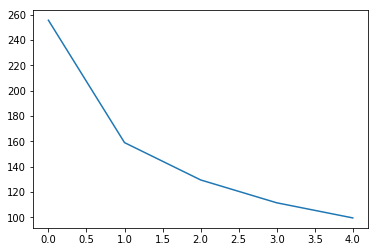

In [13]:
class TwoLayerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(28 * 28, 50), nn.ReLU(), nn.Linear(50, 10))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

two_layer_model = TwoLayerClassifier()
train(two_layer_model, epoch_count=5)

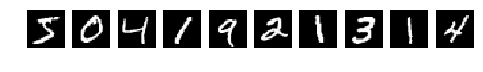

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [14]:
predict(two_layer_model, range(10))

[Epoch 0] Training loss: 135.59152714535594
[Epoch 0] Accuracy: 58525/60000 (97.54%)
[Epoch 1] Training loss: 48.29087803512812
[Epoch 1] Accuracy: 58973/60000 (98.29%)
[Epoch 2] Training loss: 37.075505069922656
[Epoch 2] Accuracy: 58994/60000 (98.32%)
[Epoch 3] Training loss: 31.766164587344974
[Epoch 3] Accuracy: 59134/60000 (98.56%)
[Epoch 4] Training loss: 28.36460825917311
[Epoch 4] Accuracy: 59365/60000 (98.94%)


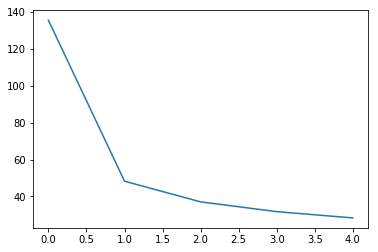

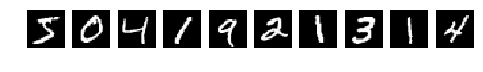

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [18]:
# Always create your models by creating a vector representing several samples
# test_entries = torch.zeros(3, 1, 28, 28)

class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1,   # Just one color channel here
                              out_channels=10, # How many channels do you want as output
                              kernel_size=5,   # Size of the convolutional layer
                              stride=1,        # Size of the step
                              padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(), 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def convolution_output_shape(self):
        xs = self.conv(torch.zeros(1, 1, 28, 28)) # One sample, with one channel, of size 28 times 28
        return xs.shape
    
    def convolution_output_length(self):
        # Never hardcode that kind of stuff, compute it!
        length = 1
        for d in self.convolution_output_shape():
            length *= d
        return length
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

convolutional_model = ConvolutionalClassifier()
train(convolutional_model, epoch_count=5)
predict(convolutional_model, range(10))